In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from scipy import signal

import sys
import os
from os import getcwd
from os.path import dirname,abspath
import pathlib as pl


import tensorflow as tf
import keras as kr

import wfdb 
import neurokit2 as neuro



home_path = "C:\\sebin\\ecg"
git_path = home_path+"\\ecg_data_wfdb"

data_path = home_path+"\\"+"data"
file_name = None

output_path = home_path+"\\save\\china"

sys.path.append(git_path)
import use.mitbih_ecg.form as wf_ecg
from use.segment.pick import random_ecg
from use.segment.open import ecgtodf
from use.tensor.input import x_tensor_input,y_tensor_input



In [2]:
#china data : http://www.icbeb.org/CPSC2021
#annotation : https://archive.physionet.org/physiobank/annotations.shtml

In [3]:
data_path = data_path+"\\china\\training_1"

In [4]:
data_file = []
for i in os.listdir(data_path):
    if i.endswith(".dat"):
        data_file.append(i)

In [5]:
data_file

['data_0_1.dat',
 'data_0_10.dat',
 'data_0_11.dat',
 'data_0_12.dat',
 'data_0_13.dat',
 'data_0_14.dat',
 'data_0_15.dat',
 'data_0_2.dat',
 'data_0_3.dat',
 'data_0_4.dat',
 'data_0_5.dat',
 'data_0_6.dat',
 'data_0_7.dat',
 'data_0_8.dat',
 'data_0_9.dat',
 'data_10_1.dat',
 'data_10_10.dat',
 'data_10_11.dat',
 'data_10_12.dat',
 'data_10_13.dat',
 'data_10_14.dat',
 'data_10_2.dat',
 'data_10_3.dat',
 'data_10_4.dat',
 'data_10_5.dat',
 'data_10_6.dat',
 'data_10_7.dat',
 'data_10_8.dat',
 'data_10_9.dat',
 'data_11_1.dat',
 'data_11_2.dat',
 'data_11_3.dat',
 'data_11_4.dat',
 'data_11_5.dat',
 'data_12_1.dat',
 'data_12_2.dat',
 'data_12_3.dat',
 'data_12_4.dat',
 'data_12_5.dat',
 'data_12_6.dat',
 'data_12_7.dat',
 'data_12_8.dat',
 'data_13_1.dat',
 'data_13_10.dat',
 'data_13_11.dat',
 'data_13_12.dat',
 'data_13_13.dat',
 'data_13_14.dat',
 'data_13_15.dat',
 'data_13_16.dat',
 'data_13_17.dat',
 'data_13_18.dat',
 'data_13_19.dat',
 'data_13_2.dat',
 'data_13_20.dat',
 'd

In [6]:
def china_ecg_resampling(path):
    #path is .atr제거한 형식이다
    #null값은 -100으로 표시 


    #open data
    data = wfdb.rdsamp(path)
    ecg = data[0]
    reference = data[1]
    ann = wfdb.rdann(path,extension="atr")


    #default ecg signal(sampling rate: 200hz/s)
    ecg=ecg.T
    ecg = ecg[1]
    n = len(ecg)
    
    ann_x = ann.sample
    ann_c = ann.symbol
    if ann_x[0]<200:
        ann_x = ann_x[1:]
        ann_c = ann_c[1:]
    ann_y = np.full((n),-100,dtype='float64')
    for i in ann_x:
        #print(i)
        ann_y[i-1] = ecg[i]

    
    original = {'ecg':ecg,'ann_x':ann_x,'ann_y':ann_y,'ann_c':ann_c}


    
    
    re_ecg = signal.resample_poly(ecg,9,5)

    n = len(re_ecg)

    re_ann_x = neuro.ecg_findpeaks(re_ecg,360)['ECG_R_Peaks']
    re_ann_y = np.full((n),-100,dtype='float64')

    for i in re_ann_x:
        #print(i)
        re_ann_y[i] = re_ecg[i]
    
    
    sampling = {'ecg':re_ecg,'ann_x':re_ann_x,'ann_y':re_ann_y,'ann_c':ann_c}

    return original,sampling

In [7]:
file_name = data_file[10].rstrip(".data")

In [8]:
file_name

'data_0_5'

In [9]:
default,sampling = china_ecg_resampling(data_path+"\\"+file_name)

(0.0, 800.0)

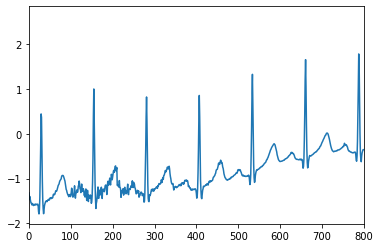

In [10]:
plt.plot(default['ecg'])
plt.xlim(0,800)

(-10.0, 10.0)

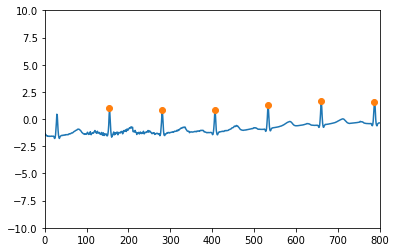

In [11]:
n = range(default['ecg'].size)
plt.plot(n,default['ecg'],n,default['ann_y'],"o")
plt.xlim((0,800))
plt.ylim(-10,10)

(0.0, 1440.0)

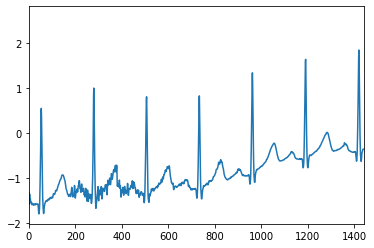

In [12]:
plt.plot(sampling['ecg'])
plt.xlim(0,1440)

(-3.0, 3.0)

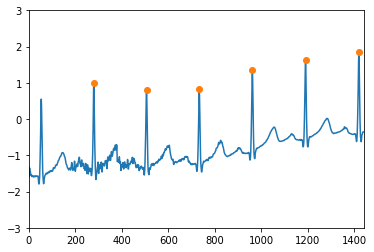

In [13]:
n = range(sampling['ecg'].size)
plt.plot(n,sampling['ecg'],n,sampling['ann_y'],"o")
plt.xlim((0,1440))
plt.ylim(-3,3)

(-10.0, 10.0)

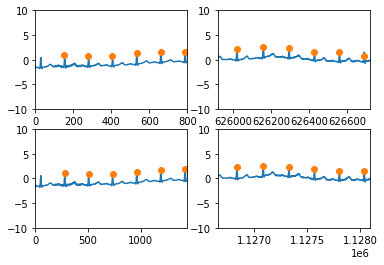

In [14]:
plt.subplot(2,2,1)

n = range(default['ecg'].size)
plt.plot(n,default['ecg'],n,default['ann_y'],"o")
plt.xlim((0,800))
plt.ylim(-10,10)

plt.subplot(2,2,2)
n = range(default['ecg'].size)
plt.plot(n,default['ecg'],n,default['ann_y'],"o")
s = default['ecg'].size
plt.xlim((s-800,s))
plt.ylim(-10,10)

plt.subplot(2,2,3)

n = range(sampling['ecg'].size)
plt.plot(n,sampling['ecg'],n,sampling['ann_y'],"o")
plt.xlim((0,1440))
plt.ylim(-10,10)

plt.subplot(2,2,4)
n = range(sampling['ecg'].size)
plt.plot(n,sampling['ecg'],n,sampling['ann_y'],"o")
s = sampling['ecg'].size
plt.xlim((s-1440,s))
plt.ylim(-10,10)



In [15]:
seg = []
size = sampling['ann_x'].size
for i in range(size):
    r = sampling['ann_x'][i]

    sepfrom = r-144
    septo = r+144

    if sepfrom <= 0:
        continue
    if septo >= sampling['ann_x'][-1]:
        break

    seg.append(sampling['ecg'][sepfrom:septo])

In [16]:
seg[0]

array([-1.0340079 , -1.02161853, -1.01651258, -1.01155028, -0.99438109,
       -0.9646672 , -0.94062098, -0.93267907, -0.93034956, -0.92987922,
       -0.92732968, -0.92784202, -0.92937356, -0.93844573, -0.95270333,
       -0.96840275, -0.98838977, -1.01107131, -1.03070543, -1.04046915,
       -1.05847353, -1.08898824, -1.12661325, -1.1653861 , -1.20605179,
       -1.23748839, -1.24965727, -1.26248442, -1.28545605, -1.31002768,
       -1.32551626, -1.34479462, -1.36080713, -1.36185376, -1.36852585,
       -1.39246013, -1.40341197, -1.37879827, -1.36287551, -1.3718178 ,
       -1.37211473, -1.35507756, -1.36243889, -1.39614166, -1.40681999,
       -1.38494514, -1.34770536, -1.30202965, -1.24190836, -1.20254931,
       -1.21734563, -1.27797743, -1.34937171, -1.39870241, -1.41453251,
       -1.39541858, -1.37422161, -1.37527529, -1.38235254, -1.33638606,
       -1.23101582, -1.16074818, -1.21272376, -1.35016818, -1.43992768,
       -1.42589433, -1.36428544, -1.33254292, -1.3254925 , -1.30

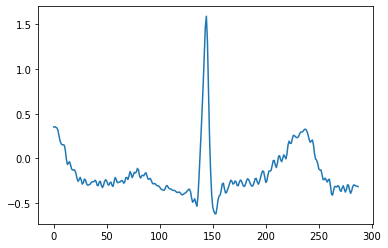

In [17]:
plt.plot(seg[-1])

In [19]:
for i in range(len(default['ann_c'])):
    if default['ann_c'][i]!= "N":
        print(i,default['ann_c'][i])

In [20]:
print(len(default['ann_c']))

3796


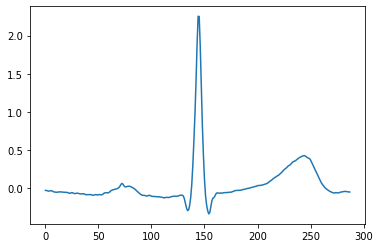

In [21]:
plt.plot(seg[1314][:])

In [ ]:
df = pd.DataFrame(seg)

In [ ]:
#8. save segment
def output_segment(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        for i in range(len(df.index)):
            data = pd.DataFrame(df.iloc[i])
            p = dir+"\\"+str(i)+".csv"
            data.to_csv(p,header=False,index=False)

In [ ]:
output_segment(output_path+"\\"+file_name)